In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to load data from the given directory
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df
# Load train, test, and validation datasets
train = data(r'E:\Finalyearproject\Enhancing-Bone-Fracture-Detection-Classification-through-Edge-Detection-ML-DL-in-Medical-Imaging-main\train')
test = data(r'E:\Finalyearproject\Enhancing-Bone-Fracture-Detection-Classification-through-Edge-Detection-ML-DL-in-Medical-Imaging-main\test')
valid = data(r'E:\Finalyearproject\Enhancing-Bone-Fracture-Detection-Classification-through-Edge-Detection-ML-DL-in-Medical-Imaging-main\valid')

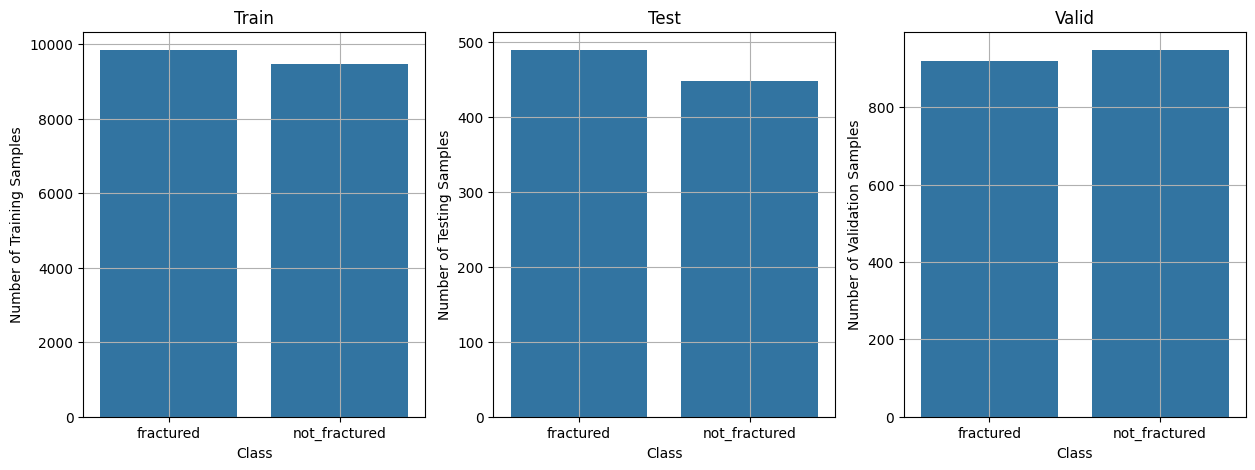

In [3]:
# Plotting class distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=train.label)
plt.xlabel("Class")
plt.ylabel("Number of Training Samples")
plt.title('Train')
plt.grid(True)
plt.subplot(1, 3, 2)
sns.countplot(x=test.label)
plt.xlabel("Class")
plt.ylabel("Number of Testing Samples")
plt.title('Test')
plt.grid(True)
plt.subplot(1, 3, 3)
sns.countplot(x=valid.label)
plt.xlabel("Class")
plt.ylabel("Number of Validation Samples")
plt.title('Valid')
plt.grid(True)
plt.show()

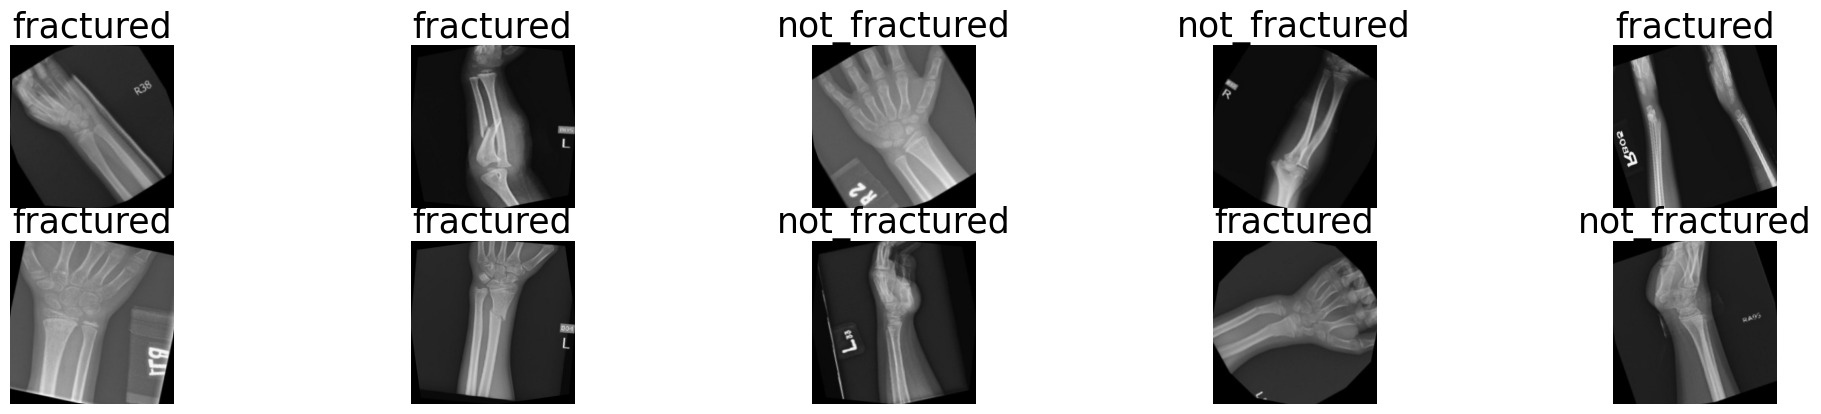

In [4]:
plt.figure(figsize=(25, 25))
for n, i in enumerate(np.random.randint(0, len(train), 10)):
    plt.subplot(10, 5, n + 1)
    img = cv2.imread(train.image[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(train.label[i], fontsize=25)

In [5]:
def preprocess_image(image_path):
    """
    Function to read an image, resize it, and apply Canny edge detection.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (224, 224))  
    edges = cv2.Canny(img, 100, 200)  
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  
    return edges

In [6]:
def preprocess_and_load(image_path):
    """
    Load image and apply preprocessing using Canny edge detection.
    This function calls preprocess_image, which already performs edge detection.
    """
    img = preprocess_image(image_path)  # Apply edge detection
    return img  # Return the edge-detected image (no further processing needed)


In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_image 
)

In [8]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
valid_generator = datagen.flow_from_dataframe(
    valid,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 19329 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1868 validated image filenames belonging to 2 classes.


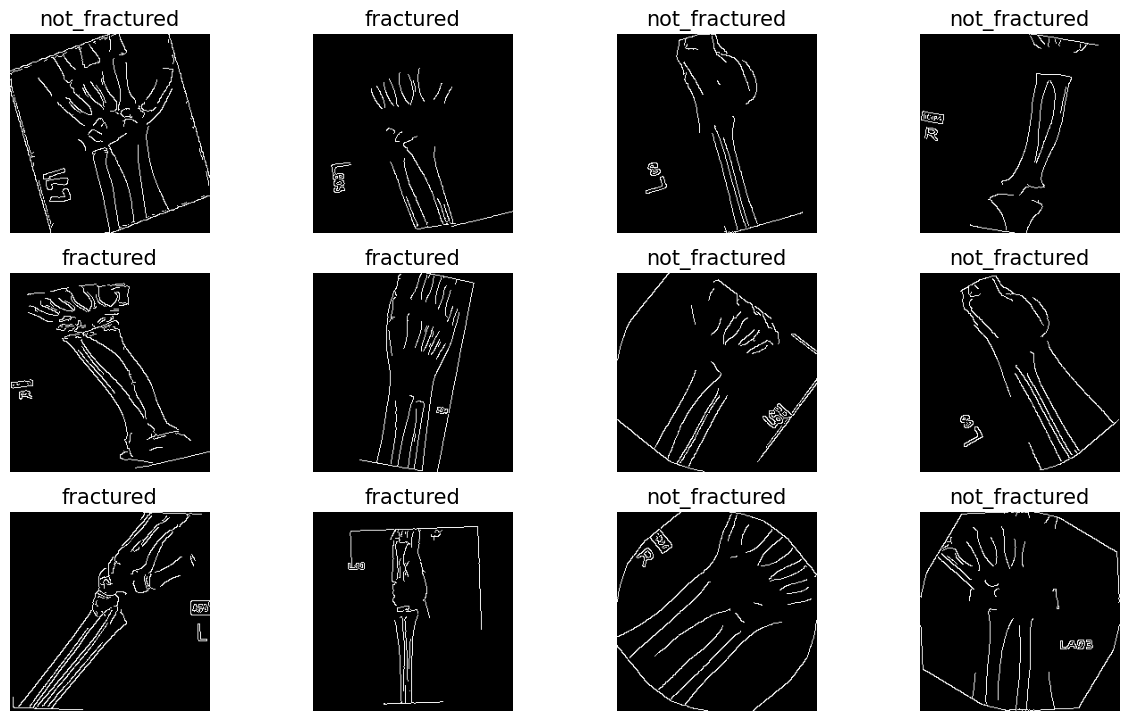

In [9]:
plt.figure(figsize=(15, 15))
for n, i in enumerate(np.random.randint(0, len(train), 12)):
    plt.subplot(5, 4, n + 1)
    img = preprocess_image(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i], fontsize=15)
plt.show()

In [10]:
class_num = 1  
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid')) 
model.summary()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\POOJITHA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,153 (1.87 MB)

 Trainable params: 488,193 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

In [12]:
from tensorflow.keras import metrics, optimizers

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.SpecificityAtSensitivity(0.5),
        metrics.AUC()
    ]
)

hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[checkpoint_cb, early_stopping_cb]
)


c:\Users\POOJITHA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6071 - auc: 0.6523 - loss: 0.9525 - specificity_at_sensitivity: 0.6910

605/605 ━━━━━━━━━━━━━━━━━━━━ 3816s 6s/step - accuracy: 0.6072 - auc: 0.6525 - loss: 0.9523 - specificity_at_sensitivity: 0.6912 - val_accuracy: 0.5027 - val_auc: 0.7858 - val_loss: 1.4066 - val_specificity_at_sensitivity: 0.8446
Epoch 2/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7961 - auc: 0.8822 - loss: 0.5360 - specificity_at_sensitivity: 0.9380

605/605 ━━━━━━━━━━━━━━━━━━━━ 1486s 2s/step - accuracy: 0.7961 - auc: 0.8823 - loss: 0.5359 - specificity_at_sensitivity: 0.9381 - val_accuracy: 0.8362 - val_auc: 0.9157 - val_loss: 0.4675 - val_specificity_at_sensitivity: 0.9500
Epoch 3/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 854s 1s/step - accuracy: 0.8815 - auc: 0.9541 - loss: 0.3410 - specificity_at_sensitivity: 0.9855 - val_accuracy: 0.5187 - val_auc: 0.7052 - val_loss: 2.5115 - val_specificity_at_sensitivity: 0.8087
Epoch 4/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 857s 1s/step - accuracy: 0.9425 - auc: 0.9860 - loss: 0.2125 - specificity_at_sensitivity: 0.9981 - val_accuracy: 0.5241 - val_auc: 0.7079 - val_loss: 2.8726 - val_specificity_at_sensitivity: 0.0000e+00
Epoch 5/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9665 - auc: 0.9938 - loss: 0.1509 - specificity_at_sensitivity: 0.9988 

605/605 ━━━━━━━━━━━━━━━━━━━━ 6811s 11s/step - accuracy: 0.9665 - auc: 0.9938 - loss: 0.1509 - specificity_at_sensitivity: 0.9988 - val_accuracy: 0.9690 - val_auc: 0.9972 - val_loss: 0.1328 - val_specificity_at_sensitivity: 1.0000
Epoch 6/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 1447s 2s/step - accuracy: 0.9784 - auc: 0.9972 - loss: 0.1121 - specificity_at_sensitivity: 0.9997 - val_accuracy: 0.8512 - val_auc: 0.9532 - val_loss: 0.4645 - val_specificity_at_sensitivity: 0.9946
Epoch 7/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 933s 2s/step - accuracy: 0.9800 - auc: 0.9975 - loss: 0.1032 - specificity_at_sensitivity: 1.0000 - val_accuracy: 0.7736 - val_auc: 0.9057 - val_loss: 1.1189 - val_specificity_at_sensitivity: 1.0000
Epoch 8/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.9854 - auc: 0.9987 - loss: 0.0819 - specificity_at_sensitivity: 0.9999 - val_accuracy: 0.6440 - val_auc: 0.8783 - val_loss: 1.6905 - val_specificity_at_sensitivity: 1.0000
Epoch 9/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 914s 2s/step

In [14]:
hist_=pd.DataFrame(hist.history)
hist_ 

accuracy       auc      loss  specificity_at_sensitivity  val_accuracy  \
0  0.674944  0.750211  0.808184                    0.809993      0.502677   
1  0.820425  0.905224  0.481908                    0.956230      0.836188   
2  0.895804  0.963443  0.310730                    0.989337      0.518737   
3  0.947178  0.987954  0.200366                    0.998172      0.524090   
4  0.968131  0.994856  0.141768                    0.998883      0.968951   
5  0.977495  0.997145  0.110667                    0.999695      0.851178   
6  0.980082  0.997879  0.100836                    1.000000      0.773555   
7  0.986445  0.998553  0.079980                    0.999797      0.644004   
8  0.986549  0.998810  0.074996                    0.999797      0.572270   
9  0.985876  0.998541  0.077663                    0.999797      0.794433   

    val_auc  val_loss  val_specificity_at_sensitivity  
0  0.785839  1.406609                        0.844565  
1  0.915704  0.467497                        0.950000  
2  0.705169  2.511456                        0.808696  
3  0.707893  2.872613                        0.000000  
4  0.997240  0.132818                        1.000000  
5  0.953173  0.464531                        0.994565  
6  0.905688  1.118923                        1.000000  
7  0.878310  1.690526                        1.000000  
8  0.724090  3.758292                        0.000000  
9  0.929058  0.749476                        0.995652

In [15]:
print(hist.history.keys())


dict_keys(['accuracy', 'auc', 'loss', 'specificity_at_sensitivity', 'val_accuracy', 'val_auc', 'val_loss', 'val_specificity_at_sensitivity'])


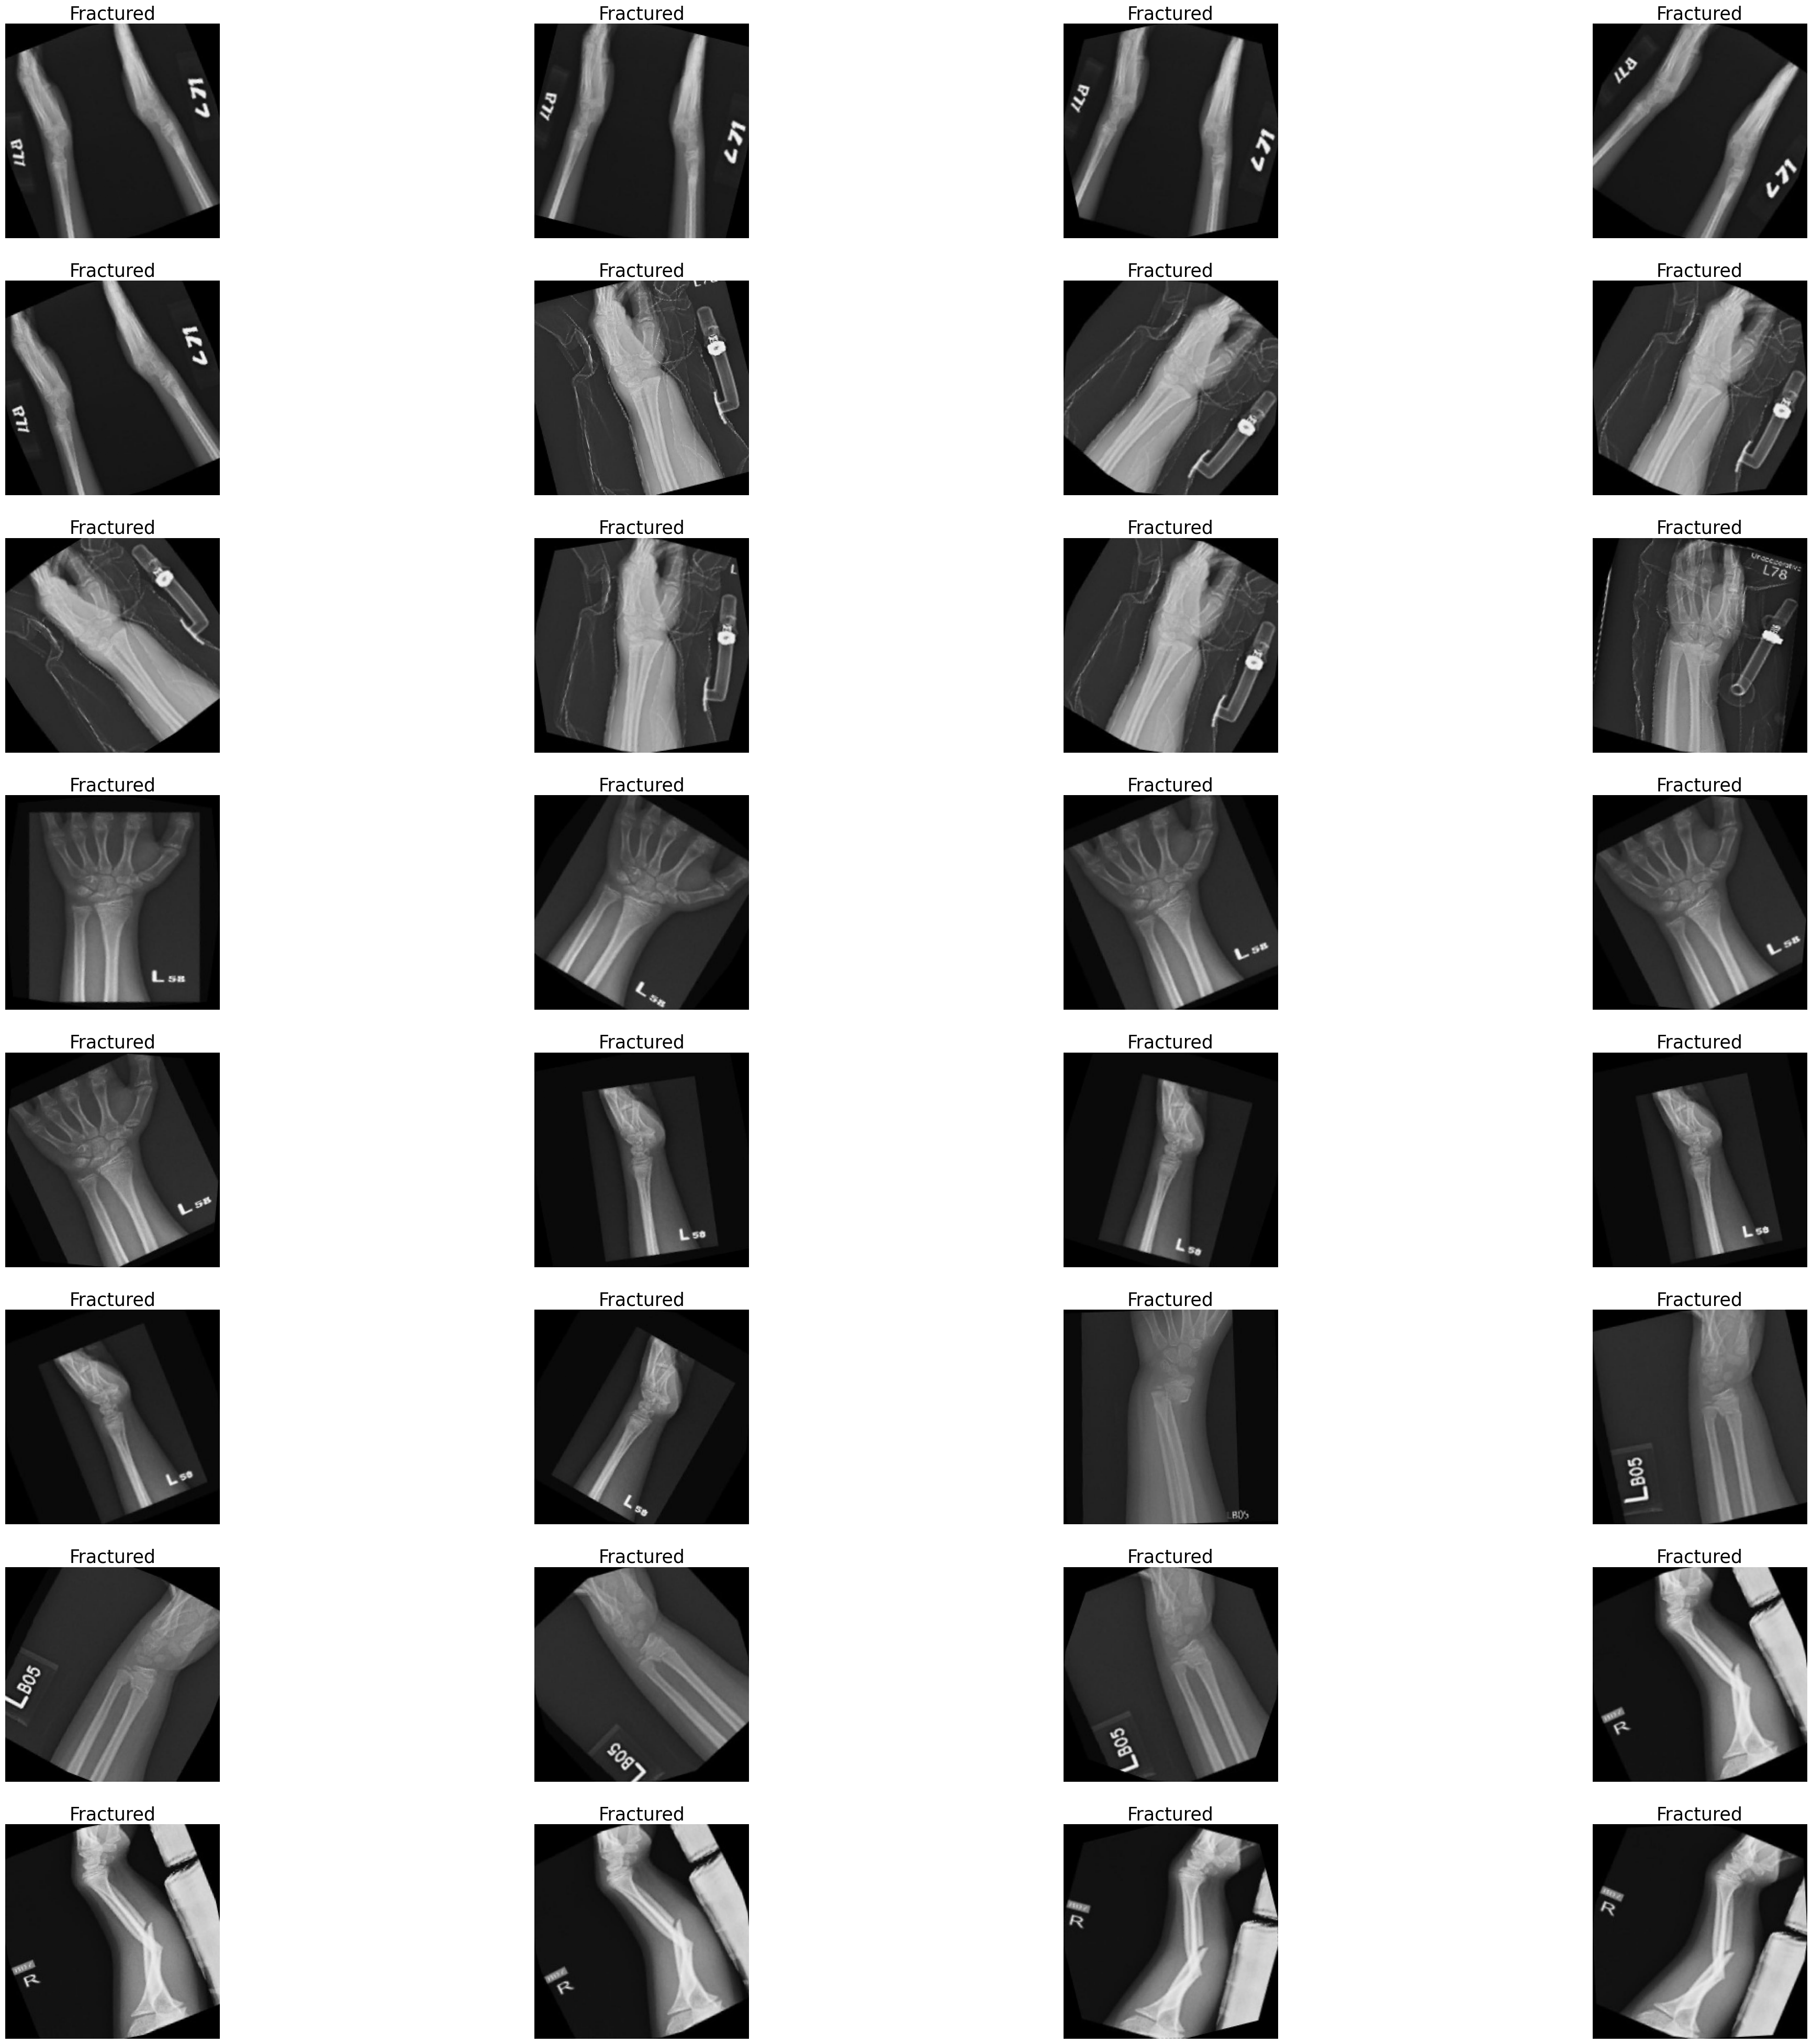

In [19]:
class_names = ['Fractured', 'Not Fractured']

# Get a batch of images and labels from the test generator
batch = next(test_generator)
images = batch[0]
labels = batch[1]  # This replaces y_test

plt.figure(figsize=(50, 50))

for n in range(len(images)):
    plt.subplot(8, 4, n + 1)
    plt.imshow(images[n])
    plt.axis('off')
    
    # Handle label format: if it's one-hot encoded, use argmax
    if labels[n].shape != ():  # If label is one-hot encoded
        label_index = int(np.argmax(labels[n]))
    else:  # If label is scalar
        label_index = int(labels[n])
    
    plt.title(class_names[label_index], fontsize=25)


In [21]:
from sklearn.metrics import classification_report
import numpy as np

# Get the true labels from the generator
test_generator.reset()
y_test = test_generator.classes  # True labels (in scalar form)

# Get model predictions (probabilities)
y_pred_probs = model.predict(test_generator)

# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Generate classification report
classificationReport = classification_report(
    y_test,
    y_pred,
    target_names=['Fractured (0)', 'Not Fractured (1)']
)

print('Classification Report:\n', classificationReport)


c:\Users\POOJITHA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step
Classification Report:
                    precision    recall  f1-score   support

    Fractured (0)       0.95      0.99      0.97       489
Not Fractured (1)       0.99      0.95      0.97       447

         accuracy                           0.97       936
        macro avg       0.97      0.97      0.97       936
     weighted avg       0.97      0.97      0.97       936



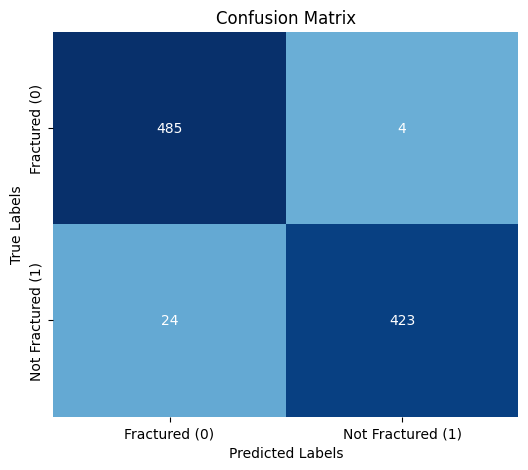

Confusion Matrix:
 [[485   4]
 [ 24 423]]


In [22]:
CM = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Blues',
            xticklabels=['Fractured (0)', 'Not Fractured (1)'],
            yticklabels=['Fractured (0)', 'Not Fractured (1)'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print('Confusion Matrix:\n', CM)

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step


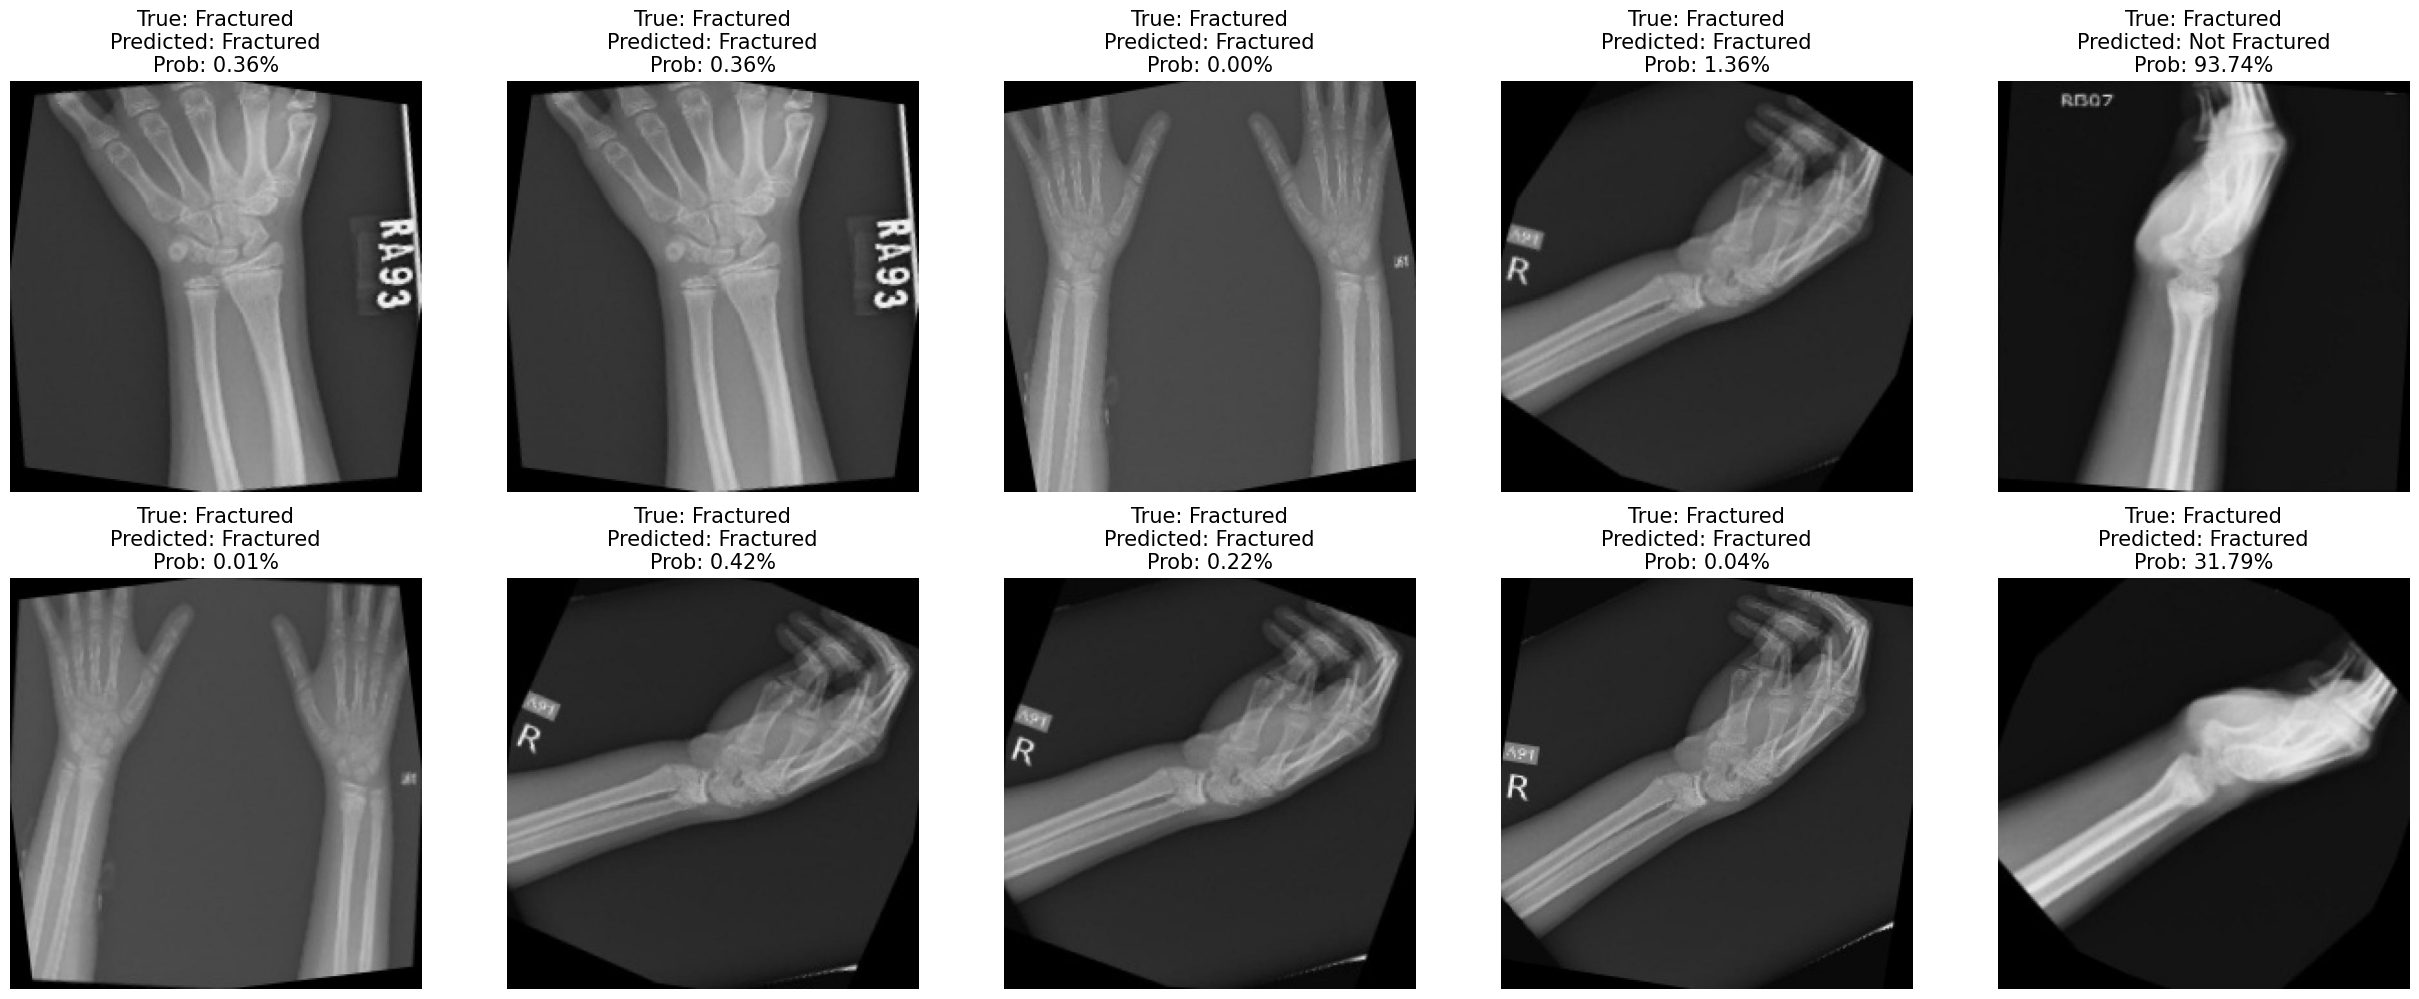

In [24]:
def display_predictions(model, test_generator, num_images=10):
    plt.figure(figsize=(25, 25))
    
   
    true_labels = test_generator.labels
    file_paths = test_generator.filepaths

    
    predictions = model.predict(test_generator).ravel() 
    predicted_classes = (predictions > 0.5).astype(int)  

    
    indices = np.random.randint(0, len(test_generator), num_images)

    for i, idx in enumerate(indices):
        
        img = cv2.imread(file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        
        plt.subplot(num_images // 2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

       
        true_label = "Fractured" if true_labels[idx] == 0 else "Not Fractured"
        predicted_label = "Fractured" if predicted_classes[idx] == 0 else "Not Fractured"
        probability = predictions[idx] * 100

        
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nProb: {probability:.2f}%', fontsize=15)

    plt.tight_layout()
    plt.show()


display_predictions(model, test_generator, num_images=10)

In [25]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow import keras


In [26]:
# Load the trained model
model = keras.models.load_model("my_keras_model.h5")

In [27]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    image = load_img(image_path, target_size=target_size)
    
    image = img_to_array(image)
   
    image = image / 255.0
    
    image = np.expand_dims(image, axis=0)
    return image
def predict_image(image_path):
    
    if not os.path.isfile(image_path):
        print(f"Error: The file '{image_path}' does not exist. Please check the path.")
        return None
    
    
    processed_image = preprocess_image(image_path)
    
    prediction = model.predict(processed_image)
    class_names = ['Fractured', 'Not Fractured']
    
    predicted_label = class_names[1] if score >= threshold else class_names[0]
    
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({score:.2e})")  
    plt.axis('off')
    plt.show()
    
    return predicted_label
    score = prediction[0][0]
    
    threshold = 0.5
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


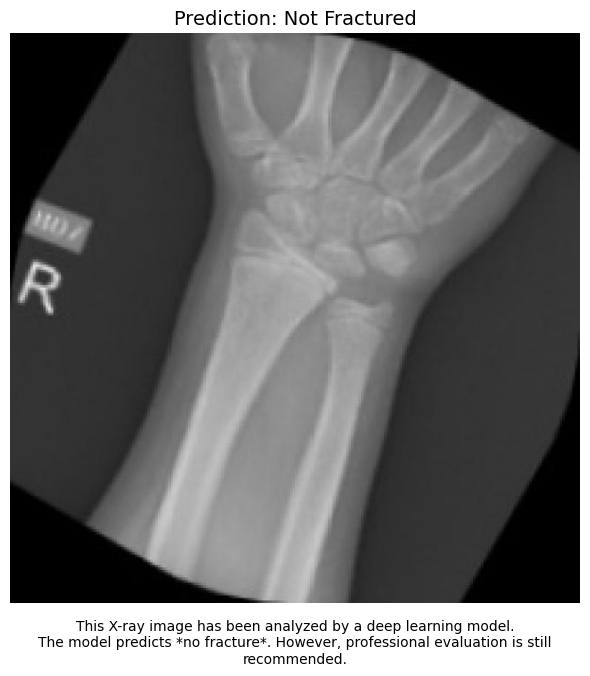

In [31]:
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(image_path, model, threshold=0.5):
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Prediction
    prediction = model.predict(img_array)
    score = prediction[0][0]
    
    class_names = ['Fractured', 'Not Fractured']
    predicted_label = class_names[1] if score >= threshold else class_names[0]

    return predicted_label

# Path to the image
sample_image_path = r'E:\Finalyearproject\Enhancing-Bone-Fracture-Detection-Classification-through-Edge-Detection-ML-DL-in-Medical-Imaging-main\test\not_fractured\fracture.jpg'

# Predict
predicted_label = predict_image(sample_image_path, model)

# Load image for display
img = cv2.imread(sample_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(6, 7))
plt.imshow(img)
plt.axis('off')

# Title with predicted label (no confidence)
plt.title(f'Prediction: {predicted_label}', fontsize=14)

# Add description below the image
description = "This X-ray image has been analyzed by a deep learning model.\n"
if predicted_label == 'Fractured':
    description += "The model predicts a *fracture is present*. Please consult a radiologist for further diagnosis."
else:
    description += "The model predicts *no fracture*. However, professional evaluation is still recommended."

plt.figtext(0.5, 0.01, description, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.show()
